In [9]:
# !pip install torch torchvision
# !pip install git+https://github.com/AlexImmer/Laplace.git
# !pip install scikit-learn matplotlib


In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

# ID
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)

# OOD
kmnist_test = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
kmnist_loader = DataLoader(kmnist_test, batch_size=1000, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.8MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 284kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.98MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.39MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [12]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    for data, target in mnist_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


In [14]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            outputs = model(data)
            predicted = outputs.argmax(dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

acc_map = evaluate(model, mnist_loader)
print(f'Baseline MLP accuracy (MAP): {acc_map:.2f}%')

Baseline MLP accuracy (MAP): 86.51%


In [16]:
from laplace import Laplace

la = Laplace(model, 'classification', subset_of_weights='last_layer', hessian_structure='kron')
la.fit(mnist_loader)
la.optimize_prior_precision(method='gridsearch', val_loader=mnist_loader)

# === Evaluate with LA predictive ===
correct = 0
total = 0
for data, target in mnist_loader:
    preds = la(data, link_approx='probit')
    predicted = preds.argmax(1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

acc_la = 100 * correct / total
print(f'Post-Laplace MLP accuracy: {acc_la:.2f}%')

# === Report difference ===
print(f'Accuracy delta: {acc_la - acc_map:.2f}%')

Post-Laplace MLP accuracy: 86.51%
Accuracy delta: 0.00%


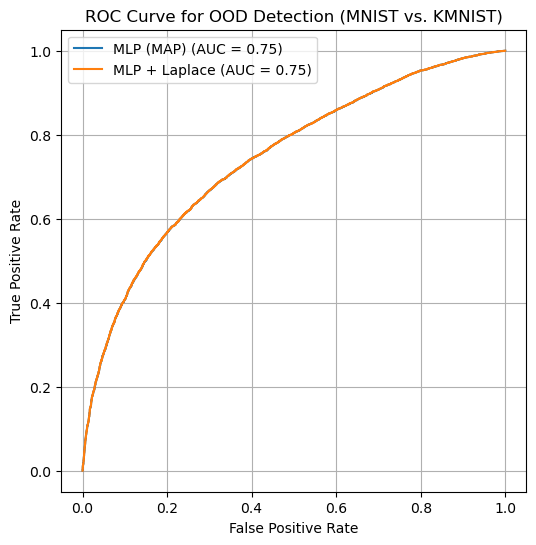

In [17]:
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

def get_confidence_scores(model, loader, use_laplace=False, la_model=None):
    scores = []
    model.eval()
    with torch.no_grad():
        for data, _ in loader:
            if use_laplace and la_model is not None:
                probs = la_model(data, link_approx='probit')
            else:
                output = model(data)
                probs = F.softmax(output, dim=1)
            scores.extend(probs.max(dim=1).values.cpu().numpy())
    return scores

id_scores_map = get_confidence_scores(model, mnist_loader)
ood_scores_map = get_confidence_scores(model, kmnist_loader)

id_scores_la = get_confidence_scores(model, mnist_loader, use_laplace=True, la_model=la)
ood_scores_la = get_confidence_scores(model, kmnist_loader, use_laplace=True, la_model=la)

# ROC curves
def plot_roc_curve(id_scores, ood_scores, label='Model'):
    y_true = [1]*len(id_scores) + [0]*len(ood_scores)
    y_scores = id_scores + ood_scores
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(6, 6))
plot_roc_curve(id_scores_map, ood_scores_map, label='MLP (MAP)')
plot_roc_curve(id_scores_la, ood_scores_la, label='MLP + Laplace')
plt.title('ROC Curve for OOD Detection (MNIST vs. KMNIST)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()